In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
import folium

# load the census shape and tract
census_shape = gpd.read_file('shape/lda_000a21a_e/lda_000a21a_e.shp')
census_tract = pd.read_csv('csv/census_ontario_selected_columns.csv')

# Store the ontario stats separately
ontario_stats = census_tract.iloc[1]

# Filter for Ontario only
census_shape = census_shape[census_shape['PRUID'] == '35']

# drop PRUID and DGUID as unncessary and convert object to int column
census_shape.drop(columns=['PRUID', 'DGUID'], inplace=True)
census_shape['DAUID'] = census_shape['DAUID'].values.astype(int)

# merge the columns together
census_df = pd.merge(census_tract, census_shape, left_on='ALT_GEO_CODE', right_on='DAUID', how='inner')

# Convert to geodataframe
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry')

# Convert to WGS84 projection
census_gdf.to_crs('WGS84', inplace=True)

# load the pharmacy data
pharmacy_df = pd.read_csv('csv/Fixed OCP Search.csv')

# Get only active pharmacy
pharmacy_df = pharmacy_df[pharmacy_df['Status'] == 'Active']

# Convert to geodataframe
pharmacy_gpf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['Longitude'], pharmacy_df['Latitude']))

# load the doctor data
doctor_pf = pd.read_csv('csv/doctors.csv')

# Convert to geodataframe
doctor_gpf = gpd.GeoDataFrame(doctor_pf, geometry=gpd.points_from_xy(doctor_pf['Longitude'], doctor_pf['Latitude']))

# FIlter for locations within the bounding box
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.x > -85) & (doctor_gpf.centroid.x < -77)]
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.y < 46) & (doctor_gpf.centroid.y > 40)]

phamracy_gpf = pharmacy_gpf[(pharmacy_gpf.centroid.x > -85) & (pharmacy_gpf.centroid.x < -77)]
pharmacy_gpf = pharmacy_gpf[(pharmacy_gpf.centroid.y < 46) & (pharmacy_gpf.centroid.y > 40)]

census_gdf = census_gdf[(census_gdf.centroid.y < 46) & (census_gdf.centroid.y > 40)]

C:\Users\shann\AppData\Local\Temp\ipykernel_28276\2381025925.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_gdf = census_gdf[(census_gdf.centroid.y < 46) & (census_gdf.centroid.y > 40)]


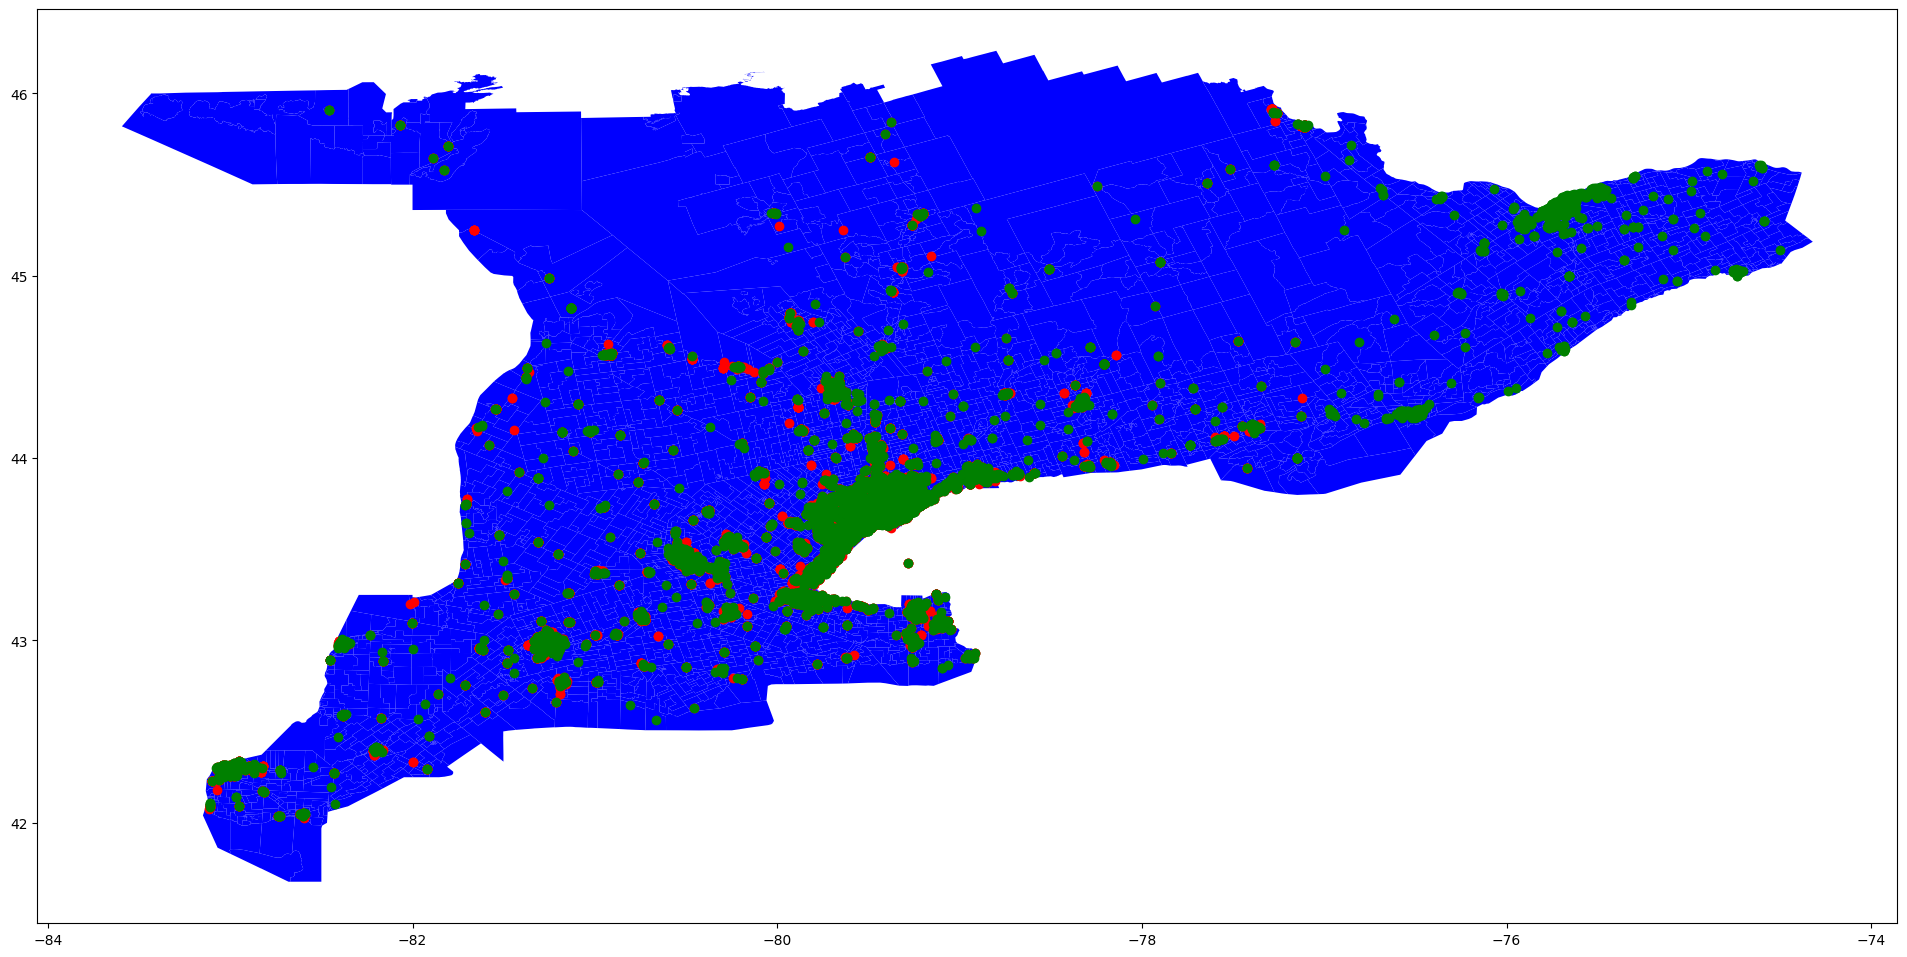

In [33]:
fig, ax = plt.subplots(figsize=(24, 24))

census_gdf.plot(ax=ax, color='blue')
doctor_gpf.plot(ax=ax, color='red')
pharmacy_gpf.plot(ax=ax, color='green')

plt.show()

In [39]:
census_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich